In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions_configs import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

import PyMieScatt as pms
from analyzing_functions import *

seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Load models

In [2]:
model_name_iv = 'forward_model/surrogate_model'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_iv1/models'

model_name_fw = 'forward_model/surrogate_model'
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1/models'
plot_dir= '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1/plots_meas'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [3]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

In [4]:
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)


# Load data

In [5]:
# measurement data  - need to be divided by (4*np.pi)
meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'

qoi_meas = pd.read_hdf(meas_datafile,'qoi')
dvar_meas = pd.read_hdf(meas_datafile,'dvar')
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.292988     10.202447     10.157936     10.068842      9.942028   
1     319.713326    311.680040    305.246269    301.256849    291.003992   
2     171.628669    169.025406    158.073357    153.320459    158.689681   
3     255.490087    263.406212    248.650204    191.072936    193.379311   
4     169.661308    155.736160    131.068012    120.460237    113.132208   
5      11.623200     11.522790     11.485159     11.458338     11.334892   
6      31.195179     30.793104     30.730566     30.576065     30.276192   
7      69.230554     68.843726     68.329483     68.201156     67.597278   
8     150.179422    149.474910    147.978382    146.385494    144.246849   
9     123.497759    122.980150    121.288541    121.158893    119.360380   
10    241.011311    237.770535    234.895710    232.139757    228.766429   
11    188.023911    182.209560    177.159020    172.017967    166.335981   
12    356.248809    348.305503    337.111139    324.849469    316.144836   
13     97.698322     91.911165    114.354964    112.676577    101.879081   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.933527      9.899784      9.816825      9.784930      9.716613  ...   
1     278.475044    274.752536    273.223423    267.624397    256.391614  ...   
2     157.512209    147.067530    133.207793    114.915648    109.312189  ...   
3     192.970691    157.444078    131.005377    101.921150     72.523689  ...   
4      93.974540     71.949823     57.866504     49.493270     41.002167  ...   
5      11.293051     11.320542     11.206947     11.150377     11.141497  ...   
6      29.963659     29.745276     29.570581     29.269259     28.896808  ...   
7      66.456888     65.266585     64.066910     63.034934     62.091119  ...   
8     141.770377    139.398776    136.896733    135.392823    133.886400  ...   
9     116.715543    114.625422    112.745620    110.197502    107.388154  ...   
10    221.139446    213.688628    209.061573    206.097833    200.159731  ...   
11    162.174808    158.447923    153.780910    146.588038    139.157964  ...   
12    299.782826    292.176839    284.467388    260.428515    240.398889  ...   
13     95.227836     94.071005     90.683122     81.403601     67.999321  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [6]:
# Pymiescatt simulation of dvar_meas - truncated angles need to be removed
qoi_meas_pymiescatt = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
qoi_meas_pymiescatt

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [7]:
# Processed version of qoi_meas - need to be divided by (4*np.pi)
qoi_meas_preprocessed = pd.read_csv('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_qoi.txt')
qoi_meas_preprocessed = qoi_meas_preprocessed.drop(['Unnamed: 0'], axis = 1)
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.296788     10.205574     10.161950     10.073487      9.943219   
1     319.779352    311.747859    305.310004    301.307994    291.052387   
2     171.675870    169.061589    158.103149    153.350741    158.728432   
3     255.561578    263.482330    248.702459    191.112573    193.423337   
4     169.706184    155.755448    131.101031    120.469612    113.130104   
5      11.624838     11.523947     11.487458     11.461293     11.335395   
6      31.200539     30.792264     30.732224     30.580233     30.276894   
7      69.233568     68.842020     68.327381     68.199014     67.595073   
8     150.211461    149.495152    147.999755    146.407612    144.265127   
9     123.526875    122.993685    121.299332    121.170892    119.371122   
10    241.075302    237.814939    234.940610    232.185053    228.807393   
11    188.077467    182.244118    177.189778    172.045359    166.358831   
12    356.289523    348.342938    337.152942    324.906405    316.194737   
13     97.748704     91.944864    114.392993    112.689452    101.890084   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.932848      9.898133      9.812126      9.780692      9.713143  ...   
1     278.527277    274.810342    273.276961    267.670406    256.429970  ...   
2     157.553536    147.105122    133.240790    114.931483    109.322211  ...   
3     193.023367    157.498141    131.035870    101.940804     72.543582  ...   
4      93.978311     71.961964     57.870742     49.497148     41.000065  ...   
5      11.292185     11.318596     11.203328     11.143059     11.132492  ...   
6      29.964346     29.746688     29.569510     29.268835     28.897714  ...   
7      66.455947     65.265902     64.064075     63.030589     62.087433  ...   
8     141.788059    139.418343    136.915128    135.413765    133.908431  ...   
9     116.727059    114.638491    112.756318    110.207570    107.400512  ...   
10    221.175056    213.726160    209.100270    206.119219    200.170367  ...   
11    162.200239    158.477975    153.810887    146.616963    139.183722  ...   
12    299.822877    292.228769    284.521563    260.474723    240.432240  ...   
13     95.241581     94.076989     90.692855     81.414035     68.016267  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

# Apply logarithm and other preprocessing of data

In [8]:
qoi_meas_pymiescatt
#qoi_meas_preprocessed

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [9]:
F11_columns_meas = [x for x in qoi_meas.columns if 'F11' in x]
F11_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]
PPF_columns_meas = [x for x in qoi_meas.columns if 'PPF' in x]
PPF_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'PPF' in x]

In [10]:
qoi_meas[F11_columns_meas] = np.log(qoi_meas[F11_columns_meas]/4/np.pi)
qoi_meas_preprocessed[F11_columns_meas] = np.log(qoi_meas_preprocessed[F11_columns_meas]/4/np.pi)
qoi_meas_pymiescatt[F11_columns_pms] = np.log(qoi_meas_pymiescatt[F11_columns_pms])


In [11]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
F11_list = []
PPF_list = []
for angle in angles:
    F11_list.append('F11_'+str(angle))
    PPF_list.append('PPF_'+str(angle))
qoi_col_list = np.concatenate([np.array(F11_list),np.array(PPF_list)])

In [12]:
qoi_meas_pymiescatt = qoi_meas_pymiescatt[qoi_col_list]

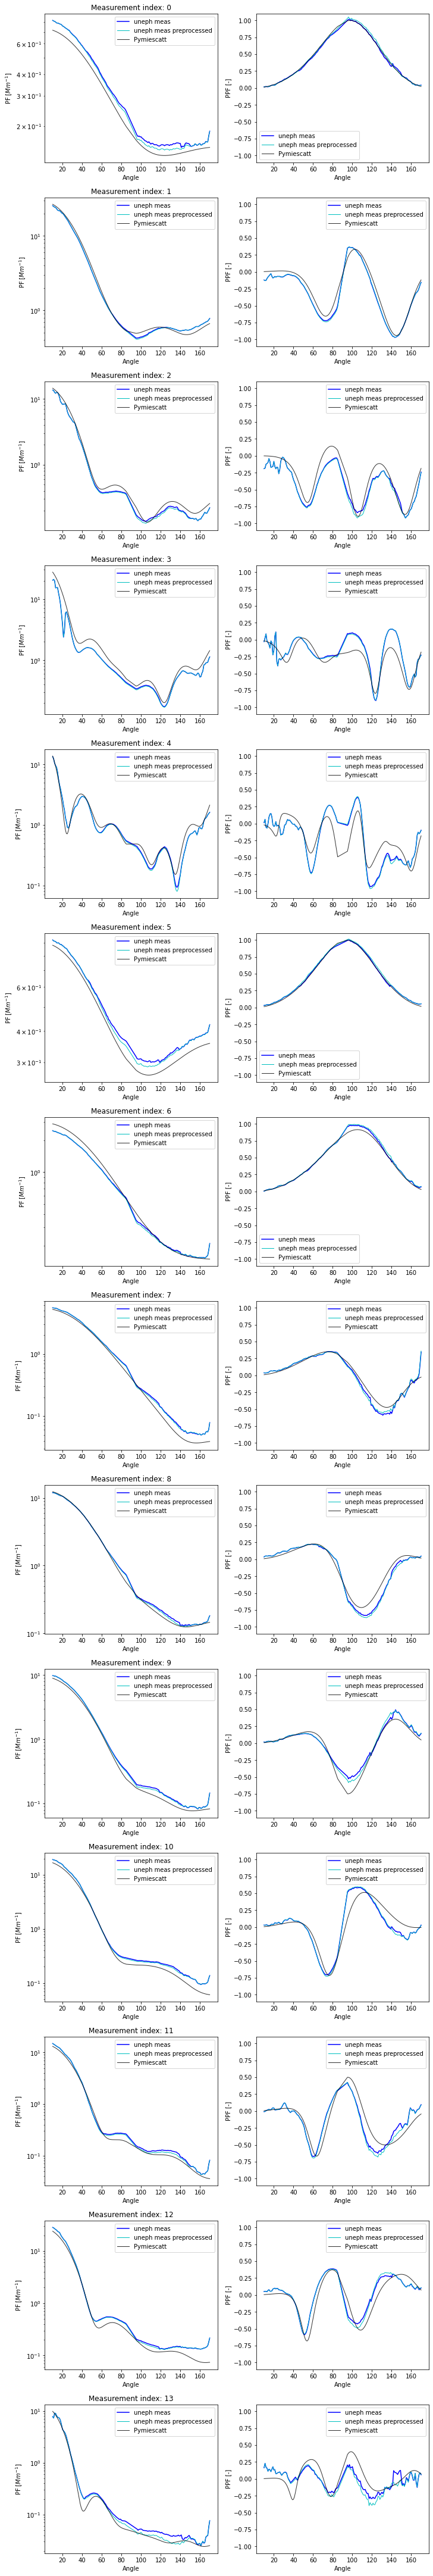

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements.jpg')


In [14]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199561     -0.208397     -0.212769     -0.221579     -0.234253   
1       3.236400      3.210953      3.190095      3.176939      3.142313   
2       2.614309      2.599025      2.532035      2.501506      2.535926   
3       3.012159      3.042673      2.985023      2.721631      2.733629   
4       2.602780      2.517139      2.344692      2.260295      2.197533   
5      -0.078021     -0.086697     -0.089969     -0.092307     -0.103138   
6       0.909239      0.896267      0.894234      0.889193      0.879337   
7       1.706418      1.700815      1.693317      1.691437      1.682543   
8       2.480806      2.476104      2.466042      2.455219      2.440502   
9       2.285199      2.280999      2.267148      2.266079      2.251123   
10      2.953820      2.940282      2.928117      2.916315      2.901677   
11      2.705545      2.674133      2.646023      2.616575      2.582985   
12      3.344605      3.322056      3.289388      3.252338      3.225176   
13      2.050860      1.989798      2.208283      2.193497      2.092762   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235109     -0.238511     -0.246926     -0.250181     -0.257187  ...   
1       3.098304      3.084847      3.079266      3.058560      3.015682  ...   
2       2.528479      2.459868      2.360886      2.213174      2.163184  ...   
3       2.731514      2.528046      2.344214      2.093175      1.752889  ...   
4       2.012000      1.744945      1.527114      1.370812      1.182601  ...   
5      -0.106837     -0.104405     -0.114490     -0.119551     -0.120348  ...   
6       0.868961      0.861646      0.855756      0.845514      0.832707  ...   
7       1.665529      1.647456      1.628904      1.612665      1.597579  ...   
8       2.423184      2.406314      2.388203      2.377156      2.365967  ...   
9       2.228715      2.210645      2.194110      2.171250      2.145426  ...   
10      2.867769      2.833496      2.811605      2.797327      2.768091  ...   
11      2.557651      2.534402      2.504505      2.456602      2.404585  ...   
12      3.172034      3.146335      3.119594      3.031304      2.951275  ...   
13      2.025248      2.013026      1.976347      1.868395      1.688473  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [15]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199192     -0.208090     -0.212374     -0.221117     -0.234133   
1       3.236607      3.211170      3.190303      3.177109      3.142479   
2       2.614584      2.599239      2.532223      2.501703      2.536171   
3       3.012439      3.042962      2.985233      2.721838      2.733857   
4       2.603044      2.517263      2.344944      2.260373      2.197514   
5      -0.077880     -0.086597     -0.089768     -0.092049     -0.103094   
6       0.909411      0.896239      0.894288      0.889330      0.879361   
7       1.706462      1.700790      1.693286      1.691406      1.682511   
8       2.481020      2.476240      2.466186      2.455370      2.440629   
9       2.285434      2.281109      2.267237      2.266178      2.251213   
10      2.954085      2.940469      2.928309      2.916510      2.901856   
11      2.705830      2.674323      2.646197      2.616734      2.583123   
12      3.344719      3.322163      3.289512      3.252513      3.225334   
13      2.051376      1.990165      2.208616      2.193612      2.092870   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235177     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.098492      3.085057      3.079462      3.058732      3.015831  ...   
2       2.528741      2.460123      2.361134      2.213312      2.163275  ...   
3       2.731787      2.528389      2.344447      2.093368      1.753163  ...   
4       2.012040      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.106913     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.868984      0.861694      0.855720      0.845499      0.832738  ...   
7       1.665515      1.647445      1.628860      1.612596      1.597519  ...   
8       2.423309      2.406455      2.388337      2.377311      2.366132  ...   
9       2.228814      2.210759      2.194205      2.171341      2.145541  ...   
10      2.867930      2.833671      2.811790      2.797430      2.768145  ...   
11      2.557807      2.534591      2.504700      2.456799      2.404771  ...   
12      3.172168      3.146513      3.119785      3.031482      2.951414  ...   
13      2.025392      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

In [16]:
qoi_meas_pymiescatt

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.330722 -0.335406 -0.340532 -0.346100 -0.352109 -0.358556 -0.365442   
1   3.279742  3.262431  3.243463  3.222838  3.200552  3.176605  3.150995   
2   2.681297  2.656183  2.628618  2.598585  2.566067  2.531043  2.493492   
3   3.316615  3.261761  3.201326  3.135219  3.063343  2.985599  2.901892   
4   2.626295  2.509020  2.377339  2.230161  2.066209  1.884021  1.681980   
5  -0.126536 -0.130674 -0.135202 -0.140119 -0.145425 -0.151117 -0.157195   
6   1.057597  1.052010  1.045895  1.039251  1.032082  1.024387  1.016169   
7   1.647584  1.639660  1.630986  1.621563  1.611393  1.600476  1.588815   
8   2.512474  2.502008  2.490545  2.478086  2.464630  2.450179  2.434731   
9   2.191082  2.179161  2.166100  2.151899  2.136556  2.120069  2.102438   
10  2.817757  2.801281  2.783222  2.763577  2.742340  2.719508  2.695075   
11  2.576809  2.554683  2.530408  2.503972  2.475362  2.444564  2.411563   
12  3.176521  3.147132  3.114848  3.079640  3.041478  3.000329  2.956156   
13  2.287451  2.235916  2.179083  2.116835  2.049042  1.975553  1.896204   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.372765 -0.380522 -0.388714  ...  0.075290  0.067477  0.060104  0.053171   
1   3.123719  3.094777  3.064166  ... -0.426074 -0.384111 -0.343685 -0.305037   
2   2.453391  2.410716  2.365439  ... -0.638724 -0.584372 -0.528777 -0.473179   
3   2.812132  2.716245  2.614180  ... -0.659852 -0.611053 -0.555606 -0.496657   
4   1.458435  1.212017  0.942395  ... -0.690478 -0.659288 -0.610779 -0.549424   
5  -0.163656 -0.170499 -0.177722  ...  0.064931  0.058182  0.051817  0.045832   
6   1.007428  0.998166  0.988385  ...  0.105330  0.094565  0.084371  0.074750   
7   1.576411  1.563266  1.549383  ... -0.108208 -0.095673 -0.084043 -0.073306   
8   2.418287  2.400848  2.382413  ...  0.047522  0.044453  0.041145  0.037672   
9   2.083660  2.063735  2.042660  ...  0.165475  0.150214  0.135351  0.120977   
10  2.669038  2.641389  2.612124  ... -0.001929 -0.003679 -0.004958 -0.005815   
11  2.376343  2.338885  2.299171  ... -0.171137 -0.153189 -0.135917 -0.119461   
12  2.908920  2.858577  2.805079  ...  0.218257  0.202657  0.186377  0.169658   
13  1.810808  1.719155  1.621013  ...  0.119823  0.123663  0.124947  0.123646   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.046673  0.040608  0.034975  0.029769  0.024990  0.020634  
1  -0.268364 -0.233820 -0.201520 -0.171547 -0.143958 -0.118788  
2  -0.418641 -0.366030 -0.316024 -0.269131 -0.225709 -0.185992  
3  -0.436943 -0.378629 -0.323275 -0.271903 -0.225094 -0.183102  
4  -0.480965 -0.410948 -0.343714 -0.282059 -0.227385 -0.180077  
5   0.040226  0.034994  0.030136  0.025648  0.021529  0.017775  
6   0.065706  0.057241  0.049357  0.042055  0.035337  0.029202  
7  -0.063444 -0.054432 -0.046241 -0.038838 -0.032189 -0.026258  
8   0.034104  0.030503  0.026928  0.023431  0.020058  0.016851  
9   0.107174  0.094014  0.081560  0.069867  0.058980  0.048939  
10 -0.006301 -0.006468 -0.006367 -0.006051 -0.005569 -0.004967  
11 -0.103941 -0.089454 -0.076073 -0.063843 -0.052787 -0.042903  
12  0.152746  0.135886  0.119318  0.103261  0.087918  0.073464  
13  0.119858  0.113797  0.105778  0.096195  0.085485  0.074104  

[14 rows x 304 columns]

# Make predictions with the forward model fw
## from phase functions to aerosol properties

In [17]:
# prediction of measurement data
dvar_meas_pred = surr_fw.predict(qoi_meas.values)
dvar_meas_pred = pd.DataFrame(data =dvar_meas_pred, columns = dvar_meas.columns)
dvar_meas_pred_2qoi = dvar_meas_pred.copy()
dvar_meas_pred = np.exp(dvar_meas_pred)
dvar_meas_pred['GSD']=dvar_meas_pred['GSD']+1
dvar_meas_pred['n']=dvar_meas_pred['n']+1.33
dvar_meas_pred['RmedianV'] = dvar_meas_pred['RmedianV']*1e-3 # in um
dvar_meas_pred.to_csv(f'{plot_dir}/dvar_meas_pred.csv')
dvar_meas_pred

Vtot  RmedianV       GSD         n         k
0    1.601874  0.103771  1.028030  1.685340  0.312128
1   14.452043  0.413811  1.018138  1.670890  0.047310
2   16.715632  0.366816  1.006425  1.365915  0.000622
3    2.937283  0.744190  1.085695  1.330045  0.001110
4   94.188872  1.249459  1.102572  1.352570  0.002895
5    2.593381  0.080275  1.109583  2.066145  0.628046
6    2.166454  0.117902  1.081470  1.610284  0.032710
7    2.732973  0.152804  1.029956  1.726155  0.549272
8    3.690920  0.168735  1.027594  1.655937  0.237230
9    3.118387  0.187651  1.128477  1.817968  0.347331
10   4.472359  0.220159  1.056678  1.460527  0.343947
11   2.574307  0.223019  1.044048  1.562103  0.246371
12   2.349151  0.121053  1.017130  1.474916  0.030654
13   2.063685  0.317073  1.028229  1.411054  1.420815

In [18]:
dvar_meas_pred_2qoi

Vtot  RmedianV       GSD          n         k
0   0.471174  4.642185 -3.574479  -1.034679 -1.164342
1   2.670836  6.025408 -4.009766  -1.076197 -3.051040
2   2.816344  5.904862 -5.047552  -3.326610 -7.382561
3   1.077485  6.612296 -2.456966 -10.013297 -6.803215
4   4.545302  7.130466 -2.277192  -3.791154 -5.844827
5   0.952963  4.385459 -2.211075  -0.306329 -0.465141
6   0.773092  4.769853 -2.507515  -1.271951 -3.420073
7   1.005390  5.029155 -3.508031  -0.925950 -0.599161
8   1.305876  5.128330 -3.590144  -1.121051 -1.438724
9   1.137316  5.234586 -2.052004  -0.717506 -1.057476
10  1.497916  5.394350 -2.870365  -2.036175 -1.067268
11  0.945580  5.407255 -3.122475  -1.460575 -1.400916
12  0.854054  4.796227 -4.066914  -1.931603 -3.484978
13  0.724493  5.759133 -3.567400  -2.512638  0.351231

In [19]:
# prediction of processed measurement data
dvar_meas_preprocessed_pred = surr_fw.predict(qoi_meas_preprocessed.values)
dvar_meas_preprocessed_pred = pd.DataFrame(data =dvar_meas_preprocessed_pred, columns = dvar_meas.columns)
dvar_meas_preprocessed_pred_2qoi = dvar_meas_preprocessed_pred.copy()
dvar_meas_preprocessed_pred = np.exp(dvar_meas_preprocessed_pred)
dvar_meas_preprocessed_pred['GSD']=dvar_meas_preprocessed_pred['GSD']+1
dvar_meas_preprocessed_pred['n']=dvar_meas_preprocessed_pred['n']+1.33
dvar_meas_preprocessed_pred['RmedianV'] = dvar_meas_preprocessed_pred['RmedianV']*1e-3 # in um
dvar_meas_preprocessed_pred.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv')
dvar_meas_preprocessed_pred

Vtot  RmedianV       GSD         n         k
0    2.282253  0.094719  1.098790  1.605810  0.144438
1   15.126445  0.441918  1.017155  1.684604  0.051086
2   18.735961  0.400430  1.004574  1.365409  0.000493
3    2.469752  0.765063  1.095906  1.330145  0.001044
4   91.686551  1.235358  1.112921  1.352331  0.002563
5    2.775449  0.068213  1.314704  1.986861  1.063484
6    2.205506  0.109359  1.094901  1.587537  0.040446
7    2.778546  0.145201  1.035344  1.741660  0.463153
8    3.717314  0.168184  1.018326  1.644925  0.099996
9    3.108259  0.185564  1.109220  1.773922  0.339447
10   4.072338  0.213359  1.056026  1.454855  0.364869
11   2.948096  0.231310  1.053501  1.542653  0.228286
12   2.124912  0.114642  1.017286  1.433847  0.026194
13   1.759162  0.364748  1.019945  1.365345  1.869990

In [20]:
# prediction of with pymiescatt predicted measurement data
dvar_meas_pymiescatt_pred = surr_fw.predict(qoi_meas_pymiescatt.values)
dvar_meas_pymiescatt_pred = pd.DataFrame(data =dvar_meas_pymiescatt_pred, columns = dvar_meas.columns)
dvar_meas_pymiescatt_pred_2qoi = dvar_meas_pymiescatt_pred.copy()

dvar_meas_pymiescatt_pred = np.exp(dvar_meas_pymiescatt_pred)
dvar_meas_pymiescatt_pred['GSD']=dvar_meas_pymiescatt_pred['GSD']+1
dvar_meas_pymiescatt_pred['n']=dvar_meas_pymiescatt_pred['n']+1.33
dvar_meas_pymiescatt_pred['RmedianV'] = dvar_meas_pymiescatt_pred['RmedianV']*1e-3 # in um
dvar_meas_pymiescatt_pred.to_csv(f'{plot_dir}/dvar_meas_pymiescatt_pred.csv')
dvar_meas_pymiescatt_pred

Vtot  RmedianV       GSD         n         k
0    2.007901  0.100339  1.073451  1.621707  0.219551
1    7.153408  0.248732  1.055115  1.698421  0.129064
2    2.340173  0.243751  1.051657  1.481132  0.047158
3    1.484502  0.454809  1.038913  1.712518  0.004208
4   11.649386  0.722614  1.270120  1.638085  0.002875
5    2.983284  0.086044  1.094640  1.936501  0.050172
6    1.704374  0.104584  1.075348  1.619575  0.201714
7    3.335840  0.152171  1.027824  1.543419  0.321736
8    4.603035  0.163739  1.063999  1.647197  0.306543
9    2.725790  0.186584  1.097034  1.608481  0.276830
10   2.311588  0.223134  1.064901  1.466306  0.333660
11   3.061295  0.290056  1.096107  1.568875  0.195472
12   3.078300  0.093367  1.007008  1.337791  0.057028
13   1.345757  0.423964  1.041037  1.552146  0.127836

# Make predictions with the forward model iv
## from aerosol properties to phase functions

In [21]:
dvar_meas_2qoi = dvar_meas.copy()
dvar_meas_2qoi['RmedianV']= dvar_meas_2qoi['RmedianV']*1e3
dvar_meas_2qoi['GSD']= dvar_meas_2qoi['GSD']-1
dvar_meas_2qoi['n']= dvar_meas_2qoi['n']-1.33
dvar_meas_2qoi = np.log(dvar_meas_2qoi)
dvar_meas_2qoi


Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.694389  5.977485 -2.525729 -1.237874 -1.500584

In [22]:
# qoi: prediction of true data
qoi_pred = surr_iv.predict(dvar_meas_2qoi)
qoi_pred = pd.DataFrame(qoi_pred, columns = qoi_col_list)
qoi_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_pred


F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   3.756902  3.867469  3.242760  3.127762  3.578021  3.521410  2.671582   
1   3.256172  3.588235  3.456133  3.862944  4.322716  4.520309  3.883874   
2   2.937300  3.276372  3.014130  3.398418  3.844948  3.943736  3.265561   
3   3.452603  3.696878  3.469845  3.704330  4.173412  4.318997  3.756025   
4   4.188974  4.286597  4.139050  4.157566  4.472646  4.639964  4.219046   
5   1.126145  0.917040  0.961412  0.843289  0.960101  0.859283  0.725791   
6   1.020191  1.003973  0.975954  0.944617  0.894409  0.907370  0.913560   
7   1.375245  1.419693  1.413631  1.438376  1.411384  1.402921  1.413196   
8   2.326134  2.360485  2.400916  2.419817  2.397293  2.393116  2.400966   
9   2.081326  2.107507  2.131428  2.138694  2.078379  2.104900  2.103144   
10  3.195804  3.164983  3.062085  2.994083  2.845042  2.870127  2.800455   
11  2.606844  2.632505  2.627842  2.624282  2.602908  2.559949  2.530301   
12  3.155310  3.161929  3.136385  3.111152  3.070492  3.010699  2.945801   
13  2.412210  2.330539  2.257847  2.133261  2.095389  1.948447  1.857779   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   3.661166  3.927838  3.964487  ... -0.004039 -0.004385  0.041221  0.083783   
1   4.479667  4.733970  4.487900  ... -0.866831 -0.777985 -0.702548 -0.580983   
2   3.821270  4.058136  3.831640  ... -1.033245 -0.934412 -0.834405 -0.699051   
3   4.024956  4.176643  4.072008  ... -0.750349 -0.688137 -0.597776 -0.491524   
4   4.219235  4.283470  4.133825  ... -0.831563 -0.783139 -0.682732 -0.571555   
5   0.732308  0.781114  0.737526  ...  0.197960  0.174366  0.152007  0.160602   
6   0.899839  0.891538  0.935829  ...  0.126182  0.110371  0.102983  0.089293   
7   1.407084  1.389907  1.400065  ... -0.082204 -0.067752 -0.054647 -0.047231   
8   2.375854  2.352498  2.273350  ...  0.085860  0.081445  0.080288  0.071139   
9   2.092690  2.050518  1.952137  ...  0.154782  0.136210  0.131918  0.114801   
10  2.815192  2.721362  2.633504  ... -0.117496 -0.117764 -0.093167 -0.086838   
11  2.475850  2.448467  2.383374  ... -0.201005 -0.177877 -0.154933 -0.135350   
12  2.883223  2.838837  2.777023  ... -0.081524 -0.072362 -0.061145 -0.051696   
13  1.746142  1.688926  1.586437  ... -0.077721 -0.057933 -0.040993 -0.025402   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.036134  0.043352 -0.009172  0.065876  0.077208  0.050159  
1  -0.570867 -0.472355 -0.449590 -0.317220 -0.229178 -0.166104  
2  -0.660769 -0.539158 -0.502518 -0.345179 -0.239096 -0.158184  
3  -0.450504 -0.375410 -0.323549 -0.207511 -0.132027 -0.076293  
4  -0.504721 -0.423876 -0.339738 -0.240678 -0.165830 -0.098894  
5   0.140965  0.134475  0.123727  0.126381  0.087302  0.073225  
6   0.080202  0.066048  0.056472  0.051406  0.041393  0.038098  
7  -0.032628 -0.029795 -0.022914 -0.015383 -0.010334 -0.006415  
8   0.065171  0.059605  0.050385  0.042182  0.033647  0.026812  
9   0.100733  0.092187  0.077263  0.062831  0.049457  0.039670  
10 -0.077455 -0.060449 -0.051301 -0.041201 -0.029007 -0.019027  
11 -0.114859 -0.094888 -0.076868 -0.059386 -0.044289 -0.032887  
12 -0.044814 -0.032188 -0.025440 -0.013705 -0.008342 -0.004152  
13 -0.020123 -0.003284 -0.002390  0.009522  0.008922  0.010306  

[14 rows x 304 columns]

In [23]:
# qoi: prediction of measurement data

qoi_meas_pred = surr_iv.predict(dvar_meas_pred_2qoi)
qoi_meas_pred = pd.DataFrame(qoi_meas_pred, columns = qoi_col_list)
qoi_meas_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_meas_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   1.186082  1.063814  1.048695  0.974594  0.848613  0.876727  0.804153   
1   4.342644  4.393357  4.353778  4.237681  4.331427  4.295084  4.066402   
2   7.144252  6.823826  5.814195  5.531008  5.373660  4.989150  4.145576   
3   4.155694  4.306582  4.073361  4.100012  4.679922  4.392129  3.304880   
4   5.179561  5.139984  4.946809  4.578004  4.450387  3.970516  3.489539   
5   1.324696  1.380927  1.448185  1.483969  1.569887  1.532953  1.454252   
6   1.633035  1.551814  1.512663  1.469095  1.526748  1.437163  1.490407   
7   1.884639  1.866708  1.817168  1.782557  1.734163  1.676917  1.654704   
8   2.233281  2.245059  2.181408  2.157296  2.095273  2.070337  2.048820   
9   2.358471  2.360161  2.364733  2.349321  2.310889  2.293061  2.275784   
10  2.644204  2.710526  2.712748  2.701701  2.638346  2.641632  2.580479   
11  2.787574  2.804488  2.677819  2.622805  2.448773  2.506740  2.419225   
12  1.727186  1.912585  2.008281  2.142832  2.087153  1.969060  1.736943   
13  2.240323  2.236946  2.256940  2.222757  2.280968  2.265292  2.239735   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   0.747552  0.692318  0.681707  ...  0.164273  0.144128  0.129983  0.114327   
1   3.962472  3.858551  3.661594  ... -0.179535 -0.183517 -0.176456 -0.146658   
2   4.742477  4.865983  4.682775  ... -0.703016 -0.572042 -0.477664 -0.336722   
3   4.074410  4.567483  3.902971  ... -0.801813 -0.655681 -0.527980 -0.371316   
4   2.756972  2.758139  2.519165  ...  0.176529  0.059353  0.024415 -0.085642   
5   1.421738  1.412419  1.357918  ...  0.107252  0.092069  0.090850  0.086551   
6   1.471494  1.446223  1.465061  ...  0.109208  0.091377  0.072943  0.056214   
7   1.621140  1.590585  1.570787  ... -0.140786 -0.127289 -0.118459 -0.107049   
8   2.048536  1.998177  1.949456  ... -0.094291 -0.083916 -0.069855 -0.057643   
9   2.265690  2.237816  2.176420  ...  0.143533  0.126462  0.115079  0.098708   
10  2.577098  2.505747  2.426828  ...  0.103654  0.083003  0.080184  0.065325   
11  2.450202  2.307882  2.217896  ... -0.058091 -0.070459 -0.048655 -0.049763   
12  1.876598  1.775662  1.814029  ...  0.329778  0.378157  0.338907  0.332914   
13  2.192796  2.178148  2.064993  ...  0.035725  0.023970  0.016776  0.019431   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.096672  0.083067  0.065851  0.056518  0.041873  0.033569  
1  -0.135002 -0.132046 -0.123822 -0.115692 -0.105747 -0.079572  
2  -0.308111 -0.149510 -0.135817 -0.036524  0.057254  0.092437  
3  -0.359351 -0.224992 -0.252323 -0.128387 -0.065135 -0.057137  
4  -0.139635 -0.238089 -0.295955 -0.349595 -0.383623 -0.386625  
5   0.075438  0.073342  0.065238  0.065571  0.050003  0.039816  
6   0.049194  0.034815  0.033002  0.028995  0.024076  0.018612  
7  -0.096231 -0.084943 -0.075754 -0.062111 -0.051616 -0.043777  
8  -0.044442 -0.030540 -0.021388 -0.015791 -0.002799  0.002550  
9   0.084957  0.074918  0.061516  0.051622  0.041533  0.035119  
10  0.052459  0.046263  0.034466  0.028748  0.021200  0.016295  
11 -0.047848 -0.040399 -0.031431 -0.027682 -0.017339 -0.011873  
12  0.315709  0.330802  0.279461  0.267189  0.241701  0.209850  
13  0.018206  0.010887  0.012887  0.010729  0.008750  0.013407  

[14 rows x 304 columns]

In [24]:
# qoi: prediction of processed measurement data

qoi_meas_preprocessed_pred = surr_iv.predict(dvar_meas_preprocessed_pred_2qoi)
qoi_meas_preprocessed_pred = pd.DataFrame(qoi_meas_preprocessed_pred, columns = qoi_col_list)
qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv')
qoi_meas_preprocessed_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.991381  0.909446  0.924348  0.882069  0.937211  0.885005  0.845187   
1   4.318518  4.374708  4.317386  4.190069  4.251613  4.181962  3.949326   
2   7.473936  7.044307  5.965898  5.715978  5.453170  5.090874  4.232424   
3   3.811435  3.955911  3.706426  3.767779  4.194895  4.071864  3.029139   
4   4.896564  4.811648  4.621730  4.283529  4.227728  3.900575  3.592833   
5   1.125285  1.264608  1.372489  1.420901  1.528888  1.515456  1.434892   
6   1.546135  1.436661  1.367914  1.281852  1.347234  1.247605  1.255657   
7   1.845054  1.844694  1.791684  1.766719  1.697769  1.662471  1.644317   
8   2.306881  2.477627  2.693067  2.791879  2.683611  2.731138  2.707466   
9   2.276483  2.283531  2.295140  2.284913  2.249910  2.238515  2.225942   
10  2.425250  2.471853  2.472328  2.466141  2.408866  2.407720  2.369497   
11  3.011780  2.992062  2.859674  2.777248  2.605130  2.646007  2.564832   
12  1.972488  2.000277  1.885881  1.917335  1.879807  1.561766  1.189611   
13  2.479276  2.439255  2.377866  2.312233  2.282036  2.279448  2.211294   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   0.807826  0.806904  0.809019  ...  0.196319  0.176820  0.156632  0.148375   
1   3.813462  3.666629  3.465753  ... -0.218195 -0.222994 -0.210157 -0.182797   
2   4.753662  4.782415  4.573711  ... -0.782503 -0.662461 -0.557069 -0.408265   
3   3.677066  4.068274  3.625550  ... -0.525467 -0.425075 -0.335798 -0.227333   
4   3.136810  3.174567  3.025717  ...  0.235075  0.119879  0.082469 -0.031805   
5   1.384953  1.344975  1.311355  ...  0.093126  0.081121  0.081705  0.087094   
6   1.233725  1.226489  1.229153  ...  0.157058  0.134167  0.113163  0.101558   
7   1.617801  1.573899  1.569790  ... -0.126117 -0.114389 -0.100906 -0.089387   
8   2.582427  2.506942  2.427169  ... -0.440705 -0.377773 -0.320867 -0.269804   
9   2.213160  2.185895  2.118731  ...  0.163814  0.145275  0.133046  0.114972   
10  2.355945  2.287303  2.209886  ...  0.123109  0.101243  0.093826  0.076569   
11  2.600539  2.459059  2.379915  ... -0.112605 -0.117974 -0.092066 -0.087617   
12  1.393653  1.307180  1.345953  ...  0.597418  0.638560  0.604643  0.581766   
13  2.142164  2.074396  1.929287  ... -0.042914 -0.055974 -0.054039 -0.045983   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.131794  0.117545  0.105036  0.095710  0.073684  0.060841  
1  -0.169300 -0.163000 -0.151967 -0.138693 -0.125986 -0.100458  
2  -0.366132 -0.193898 -0.157293 -0.041325  0.059526  0.105114  
3  -0.234668 -0.151904 -0.202929 -0.116847 -0.077145 -0.075301  
4  -0.091726 -0.193421 -0.259064 -0.315384 -0.347810 -0.363244  
5   0.081581  0.076061  0.071209  0.067999  0.056964  0.041528  
6   0.089214  0.072518  0.068445  0.061452  0.047225  0.039803  
7  -0.077710 -0.068485 -0.060243 -0.045994 -0.039102 -0.033022  
8  -0.212812 -0.160155 -0.114763 -0.093204 -0.049898 -0.035545  
9   0.099434  0.088158  0.073136  0.061033  0.049222  0.040476  
10  0.062430  0.053319  0.040082  0.032935  0.023451  0.017662  
11 -0.081254 -0.065968 -0.053570 -0.044534 -0.028396 -0.021126  
12  0.558822  0.556526  0.474380  0.460079  0.403266  0.344665  
13 -0.041206 -0.038850 -0.027264 -0.022703 -0.016171 -0.006476  

[14 rows x 304 columns]

In [25]:
# qoi: prediction of with pymiescatt predicted measurement data

qoi_meas_pymiescatt_pred=surr_iv.predict(dvar_meas_pymiescatt_pred_2qoi)
qoi_meas_pymiescatt_pred = pd.DataFrame(qoi_meas_pymiescatt_pred, columns = qoi_col_list)
qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/qoi_meas_pymiescatt_pred.csv')
qoi_meas_pymiescatt_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.885418  0.780398  0.772833  0.717629  0.697096  0.666309  0.641876   
1   4.216852  4.222558  4.141006  4.127756  3.994604  3.993258  3.989355   
2   3.578262  3.604948  3.471965  3.621880  3.469214  3.500346  3.322603   
3   2.982737  2.815507  2.465068  2.486808  2.447288  2.320057  2.083603   
4   4.098608  3.832282  3.612503  3.438005  3.268446  3.191488  3.018214   
5   2.067393  2.036838  2.006695  1.993701  2.200987  2.131487  2.028810   
6   0.790281  0.691870  0.677257  0.617606  0.572713  0.549541  0.542720   
7   1.805238  1.796225  1.702772  1.644862  1.567864  1.488608  1.468285   
8   2.334896  2.367786  2.376274  2.393688  2.378761  2.355274  2.359606   
9   1.931911  1.952463  1.974752  1.979055  1.952151  1.940196  1.939024   
10  2.045163  2.105667  2.091205  2.065216  1.986761  1.984850  1.926786   
11  2.706819  2.740090  2.758756  2.750393  2.718397  2.672453  2.609732   
12  1.939341  2.221511  2.269614  2.307581  2.760030  2.275949  1.739808   
13  2.099808  2.043595  1.953599  1.825206  1.772321  1.641032  1.433896   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   0.608536  0.598385  0.622316  ...  0.185447  0.170401  0.152848  0.142594   
1   3.952807  3.866945  3.718605  ... -0.470388 -0.427409 -0.367544 -0.324219   
2   3.534192  3.411450  3.270688  ... -0.513063 -0.468023 -0.423277 -0.380272   
3   2.058160  2.002568  1.975867  ... -0.552067 -0.498185 -0.448671 -0.389572   
4   2.884548  2.780428  2.633636  ... -0.272392 -0.299463 -0.333401 -0.342061   
5   2.004998  2.090525  2.024230  ...  0.129505  0.100667  0.078503  0.082139   
6   0.515524  0.496943  0.534997  ...  0.175321  0.160938  0.145140  0.131750   
7   1.441495  1.399020  1.390570  ... -0.100610 -0.087233 -0.072502 -0.059944   
8   2.335434  2.316689  2.285152  ... -0.066281 -0.055496 -0.049124 -0.044950   
9   1.920980  1.895148  1.831760  ...  0.162103  0.145950  0.134566  0.115875   
10  1.925371  1.853602  1.776654  ...  0.093367  0.073325  0.071435  0.057939   
11  2.539526  2.497482  2.434562  ... -0.159578 -0.143589 -0.128668 -0.115545   
12  1.983058  2.609006  2.394180  ...  1.086679  1.106406  1.085025  1.060565   
13  1.293868  1.189438  1.076687  ... -0.254990 -0.232274 -0.205503 -0.167744   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.128184  0.114059  0.099560  0.090206  0.071891  0.062687  
1  -0.277733 -0.233140 -0.187238 -0.153462 -0.119351 -0.088370  
2  -0.347272 -0.288986 -0.259772 -0.203144 -0.143583 -0.105437  
3  -0.330647 -0.273762 -0.218136 -0.160570 -0.105183 -0.066371  
4  -0.362000 -0.374687 -0.370772 -0.371558 -0.356687 -0.322580  
5   0.064850  0.054411  0.057998  0.055394  0.034008  0.024953  
6   0.118543  0.105028  0.089897  0.079925  0.066885  0.058202  
7  -0.047802 -0.038304 -0.031369 -0.017064 -0.012502 -0.005697  
8  -0.037160 -0.033961 -0.030679 -0.026560 -0.022347 -0.019930  
9   0.101619  0.089023  0.073944  0.061227  0.049012  0.038928  
10  0.045934  0.041278  0.031333  0.025945  0.020411  0.015740  
11 -0.101249 -0.084810 -0.072572 -0.057919 -0.044545 -0.034733  
12  0.981066  0.969358  0.786389  0.794671  0.675204  0.586954  
13 -0.152755 -0.124368 -0.112104 -0.079118 -0.071460 -0.051120  

[14 rows x 304 columns]

In [26]:
np.exp(qoi_meas_pred)

F11_10      F11_11      F11_12      F11_13      F11_14      F11_15  \
0      3.274229    2.897399    2.853923    2.650091    2.336405    2.403022   
1     76.910616   80.911552   77.771717   69.247085   76.052750   73.338372   
2   1266.803165  919.495994  335.021634  252.398202  215.650708  146.811534   
3     63.796224   74.186457   58.754094   60.340990  107.761641   80.812303   
4    177.604868  170.712963  140.725237   97.319934   85.660124   53.011886   
5      3.761043    3.978589    4.255384    4.410416    4.806107    4.631835   
6      5.119388    4.720023    4.538799    4.345299    4.603182    4.208741   
7      6.583978    6.466973    6.154403    5.945036    5.664184    5.349041   
8      9.330431    9.440973    8.858774    8.647723    8.127659    7.927493   
9     10.574769   10.592661   10.641200   10.478457   10.083382    9.905206   
10    14.072240   15.037186   15.070638   14.905057   13.990046   14.036097   
11    16.241576   16.518622   14.553323   13.774311   11.574139   12.264883   
12     5.624805    6.770566    7.450502    8.523544    8.061933    7.163941   
13     9.396368    9.364688    9.553814    9.232746    9.786152    9.633936   

       F11_16      F11_17      F11_18      F11_19  ...   PPF_161   PPF_162  \
0    2.234802    2.111825    1.998342    1.977250  ...  1.178536  1.155031   
1   58.346647   52.587180   47.396620   38.923332  ...  0.835659  0.832337   
2   63.153994  114.718048  129.798532  108.069556  ...  0.495090  0.564372   
3   27.245283   58.815782   96.301461   49.549435  ...  0.448515  0.519088   
4   32.770843   15.752075   15.770475   12.418225  ...  1.193069  1.061150   
5    4.281282    4.144318    4.105876    3.888091  ...  1.113215  1.096441   
6    4.438902    4.355736    4.247045    4.327805  ...  1.115394  1.095682   
7    5.231533    5.058855    4.906617    4.810430  ...  0.868675  0.880479   
8    7.758743    7.756538    7.375601    7.024868  ...  0.910018  0.919509   
9    9.735549    9.637768    9.372841    8.814692  ...  1.154345  1.134806   
10  13.203459   13.158893   12.252710   11.322904  ...  1.109216  1.086545   
11  11.237150   11.590693   10.053108    9.187983  ...  0.943564  0.931966   
12   5.679951    6.531250    5.904186    6.135116  ...  1.390659  1.459591   
13   9.390846    8.960228    8.829938    7.885240  ...  1.036371  1.024260   

     PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169  \
0   1.138809  1.121118  1.101499  1.086615  1.068068  1.058146  1.042762   
1   0.838236  0.863589  0.873715  0.876301  0.883537  0.890750  0.899653   
2   0.620231  0.714107  0.734834  0.861129  0.873003  0.964135  1.058925   
3   0.589795  0.689826  0.698130  0.798523  0.776994  0.879513  0.936941   
4   1.024716  0.917923  0.869675  0.788133  0.743821  0.704974  0.681388   
5   1.095105  1.090407  1.078356  1.076098  1.067413  1.067768  1.051274   
6   1.075669  1.057824  1.050424  1.035428  1.033553  1.029419  1.024368   
7   0.888288  0.898482  0.908254  0.918565  0.927045  0.939779  0.949693   
8   0.932529  0.943987  0.956531  0.969922  0.978839  0.984333  0.997205   
9   1.121962  1.103744  1.088671  1.077795  1.063448  1.052977  1.042407   
10  1.083486  1.067506  1.053859  1.047350  1.035066  1.029165  1.021426   
11  0.952510  0.951455  0.953278  0.960406  0.969058  0.972698  0.982811   
12  1.403412  1.395028  1.371232  1.392084  1.322417  1.306287  1.273413   
13  1.016918  1.019621  1.018373  1.010946  1.012971  1.010786  1.008789   

     PPF_170  
0   1.034139  
1   0.923512  
2   1.096844  
3   0.944464  
4   0.679346  
5   1.040619  
6   1.018787  
7   0.957167  
8   1.002554  
9   1.035743  
10  1.016428  
11  0.988198  
12  1.233493  
13  1.013497  

[14 rows x 304 columns]

In [27]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199192     -0.208090     -0.212374     -0.221117     -0.234133   
1       3.236607      3.211170      3.190303      3.177109      3.142479   
2       2.614584      2.599239      2.532223      2.501703      2.536171   
3       3.012439      3.042962      2.985233      2.721838      2.733857   
4       2.603044      2.517263      2.344944      2.260373      2.197514   
5      -0.077880     -0.086597     -0.089768     -0.092049     -0.103094   
6       0.909411      0.896239      0.894288      0.889330      0.879361   
7       1.706462      1.700790      1.693286      1.691406      1.682511   
8       2.481020      2.476240      2.466186      2.455370      2.440629   
9       2.285434      2.281109      2.267237      2.266178      2.251213   
10      2.954085      2.940469      2.928309      2.916510      2.901856   
11      2.705830      2.674323      2.646197      2.616734      2.583123   
12      3.344719      3.322163      3.289512      3.252513      3.225334   
13      2.051376      1.990165      2.208616      2.193612      2.092870   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235177     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.098492      3.085057      3.079462      3.058732      3.015831  ...   
2       2.528741      2.460123      2.361134      2.213312      2.163275  ...   
3       2.731787      2.528389      2.344447      2.093368      1.753163  ...   
4       2.012040      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.106913     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.868984      0.861694      0.855720      0.845499      0.832738  ...   
7       1.665515      1.647445      1.628860      1.612596      1.597519  ...   
8       2.423309      2.406455      2.388337      2.377311      2.366132  ...   
9       2.228814      2.210759      2.194205      2.171341      2.145541  ...   
10      2.867930      2.833671      2.811790      2.797430      2.768145  ...   
11      2.557807      2.534591      2.504700      2.456799      2.404771  ...   
12      3.172168      3.146513      3.119785      3.031482      2.951414  ...   
13      2.025392      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

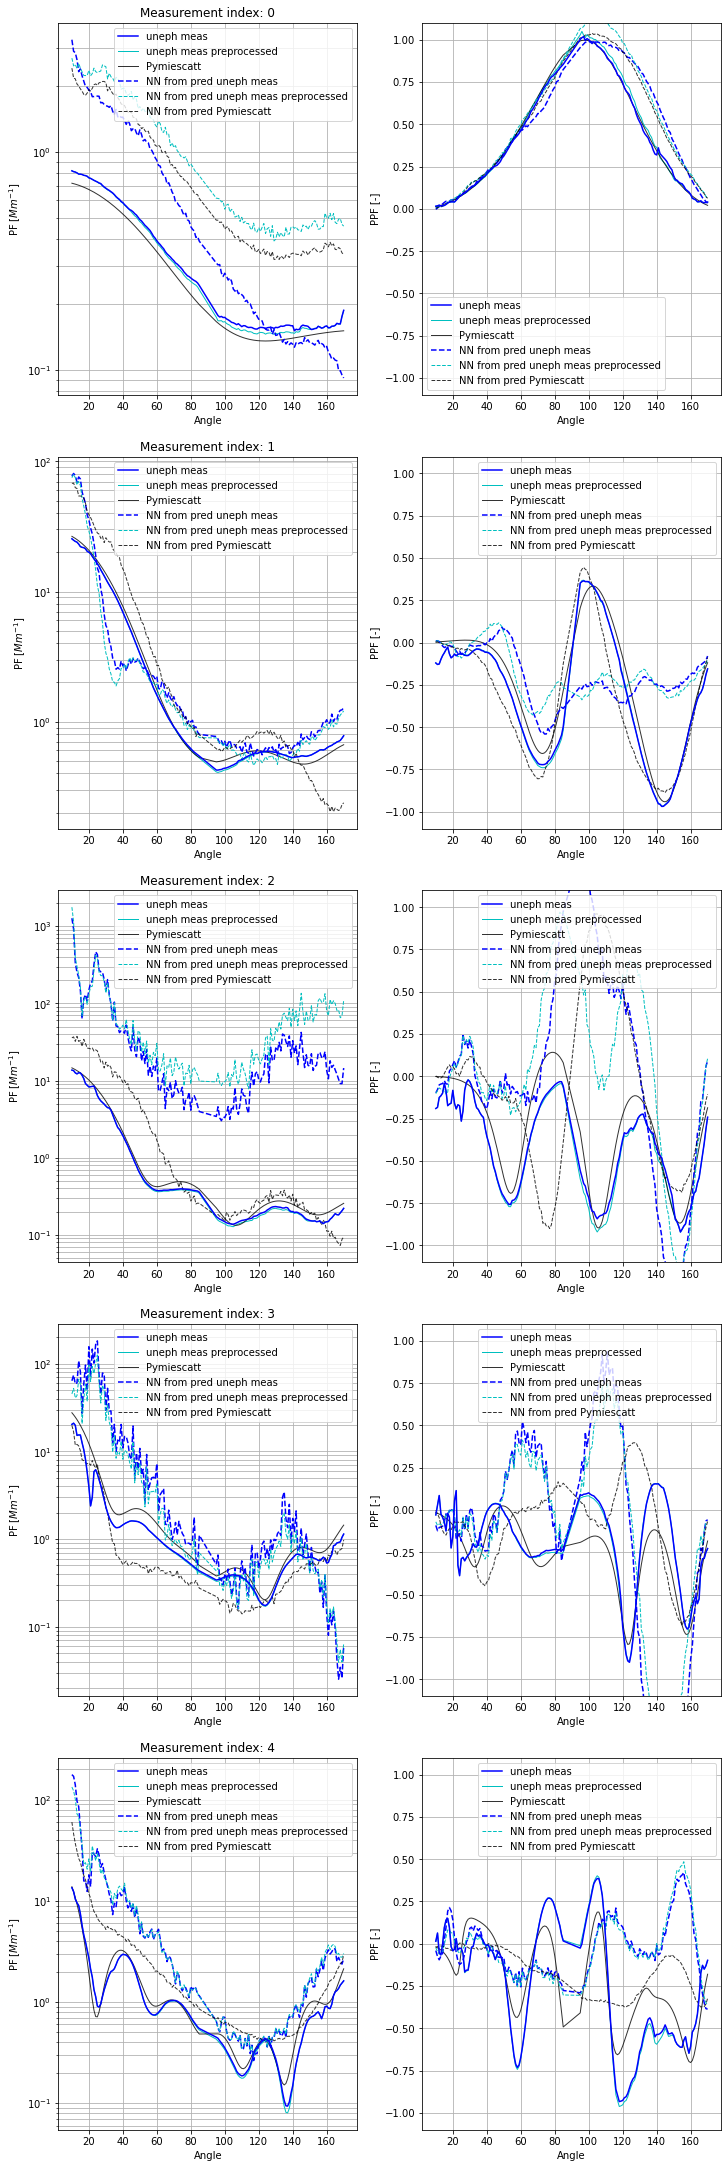

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 30), constrained_layout=True)
for index in range(5):
    axs[index,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')
    meas_pred_plot, = axs[index,1].plot(angles, (qoi_meas_pred[PPF_list].loc[index]), ls = '--',c='b',  label='NN from pred uneph meas')

    meas_prepro_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    meas_prepro_pred_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed_pred[PPF_list].loc[index], ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')
    pms_pred_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt_pred[PPF_list].loc[index], ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt') 

        
    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

        
        

        
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred0_4.jpg')


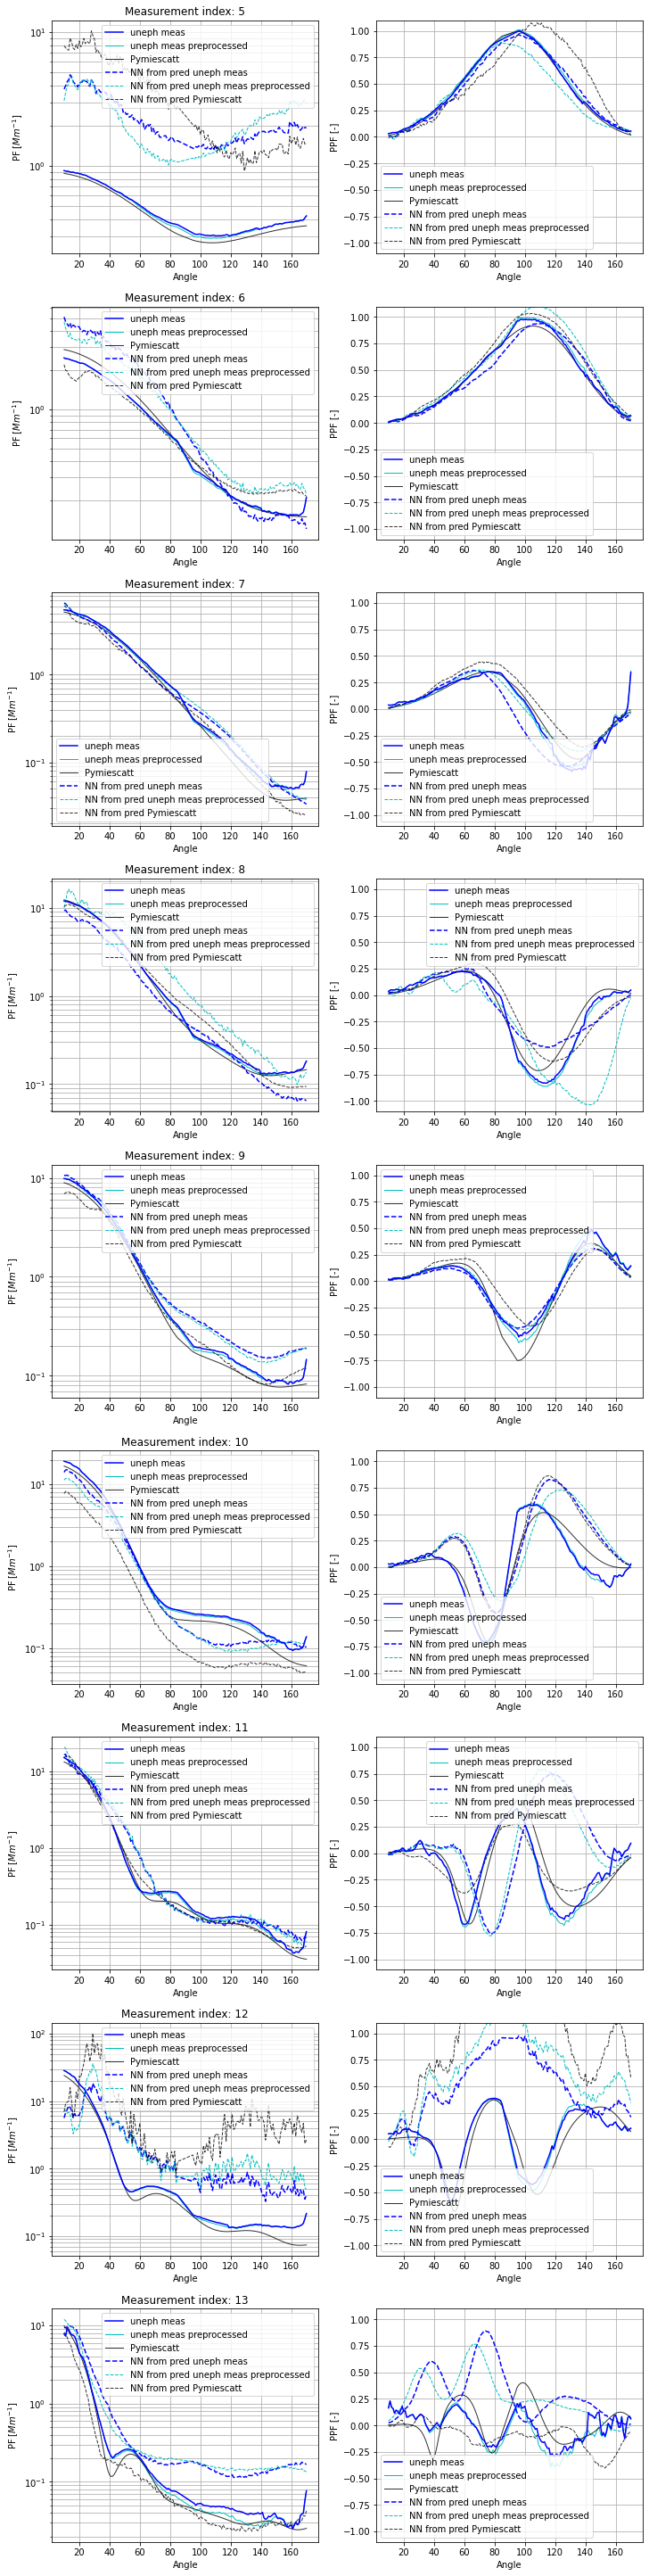

In [29]:

fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40), constrained_layout=True)
for index in range(5,14):
    axs[index-5,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index-5,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index-5,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')
    meas_pred_plot, = axs[index-5,1].plot(angles, (qoi_meas_pred[PPF_list].loc[index]), ls = '--',c='b',  label='NN from pred uneph meas')

    meas_prepro_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    meas_prepro_pred_plot, = axs[index-5,1].plot(angles, qoi_meas_preprocessed_pred[PPF_list].loc[index], ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')
    pms_pred_plot, = axs[index-5,1].plot(angles, qoi_meas_pymiescatt_pred[PPF_list].loc[index], ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt') 

        
    meas_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index-5,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

        
        

        
    axs[index-5,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index-5,1].set_ylabel('PPF [-]')
    axs[index-5,1].set_ylim(-1.1, 1.1)
    axs[index-5,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred5_13.jpg')


# Make predictions with Pymiescatt

In [30]:
D_array = np.logspace(0.1, 5, 300)

In [31]:
angles_new = np.arange(10,171)
len(angles_new)

161

In [32]:
qoi_list_pms_F11 = []
qoi_list_pms_PPF = []
qoi_list_pms = []
for i in range(10,171):
    qoi_list_pms.append('F11_'+str(i))
    qoi_list_pms_F11.append('F11_'+str(i))
for i in range(10,171):
    qoi_list_pms.append('PPF_'+str(i))
    qoi_list_pms_PPF.append('PPF_'+str(i))


In [33]:
# qoi with Pymiescatt: prediction of measurement data
pms_qoi_meas_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
#pms_qoi_meas_pred.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
pms_qoi_meas_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pred.csv') 

207.06637027073634
343.40574788744556
826.819444569567
48.760384013303465
733.5425942573609
80.86638062208623
1458.498818240502
1.7539512588697341
2428.451334339297
12.033139720324828
155.42574982425884
1256.513911898741
231.50406818765032
324.4043146329512
304.8100989549813
183.58874757033132
336.7207963499522
184.02556273562533
359.2091034360568
120.3200531063514
436.3215670471783
101.4327215415663
443.55782690431226
55.87012428643084
241.89612384325858
316.5641262240105
632.6738677132773
15.509243638331363


In [34]:

# qoi with Pymiescatt: prediction of processed measurement data
pms_qoi_meas_preprocessed_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_preprocessed_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv') 

184.46065929030087
667.2803673375455
883.0689523646697
41.897584589787776
800.8109486964293
69.67013545881538
1492.1060102026318
1.3673025650608408
2387.3134803944276
12.223871026218859
108.98257170808519
2923.858882856864
213.39094149734942
417.7507457554157
289.3525762980007
217.86085113673494
336.03478656088237
186.8243335156089
359.35492270480194
121.8845939213896
422.9312950581002
101.44442113707585
458.86508626138794
57.567763232502756
229.0828418712588
337.12474487467006
728.643895405133
8.669600969328984


In [35]:
# qoi with Pymiescatt: prediction of with pymiescatt predicted measurement data
pms_qoi_meas_pymiescatt_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pymiescatt_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv') 

197.6753693829044
485.3643764818942
493.18789913765454
112.42218377895016
483.8053503410151
39.019307630638224
905.6489657111406
3.7918780319337744
1217.4323301055483
9.533072976828471
167.91818031650573
1159.905842990195
205.88261244979893
364.2451808180428
303.65581491696855
226.77227032801284
323.7189686448301
254.6949660281778
363.6884195642887
104.1222883326187
441.0046856685576
50.565533063742826
565.6401596385093
31.10491883501305
186.70743900428647
903.0922742121472
843.8242317539026
4.246697055581842
